<a href="https://colab.research.google.com/github/TranGiaKhanh-23BI14218/Projects/blob/main/HoaPhat_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pathlib import Path
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab Notebooks/TimeSeries/HoaPhatStock - Copy.xlsx'


OUTDIR = Path("/content/drive/MyDrive/Colab Notebooks/TimeSeries/hoaphat_full_features")
OUTDIR.mkdir(parents=True, exist_ok=True)


TRAIN_START = "2/1/2018"
TRAIN_END = "28/2/2022"
TEST_START = "1/3/2022"
TEST_END = "31/3/2023"

# LSTM hyperparameter grid
# Keep these ranges modest to avoid excessive runtime; expand on Colab/GPU.
GRID = {
    "lookback": [5, 10, 20],
    "units": [32, 64],
    "batch_size": [16, 32],
    "epochs": [50, 100]  # on Colab, you can try 100+ for better convergence
}


import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:




df = pd.read_excel(file_path, sheet_name = "Dữ liệu Lịch sử HPG")

#df["Trading date"] = pd.to_datetime(df["Trading date"], dayfirst = True).dt.strftime("%m - %d - %Y")  --old preprocessing date
df = df.sort_values(by = "Trading date", ascending = True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1308 entries, 1307 to 0
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Trading date       1308 non-null   datetime64[ns]
 1   Closing price      1308 non-null   float64       
 2   Opening price      1308 non-null   float64       
 3   Highest price      1308 non-null   float64       
 4   Lowest price       1308 non-null   float64       
 5   Volume             1308 non-null   object        
 6   Percentage change  1308 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 81.8+ KB


In [ ]:
df = df[["Closing price", "Trading date"]]
df

,Closing price,Trading date
1307,9084.1,2018-01-02
1306,9065.1,2018-01-03
1305,9179.3,2018-01-04
1304,9141.2,2018-01-05
1303,9426.9,2018-01-08
...,...,...
4,15757.6,2023-03-27
3,15681.8,2023-03-28
2,15757.6,2023-03-29
1,15757.6,2023-03-30


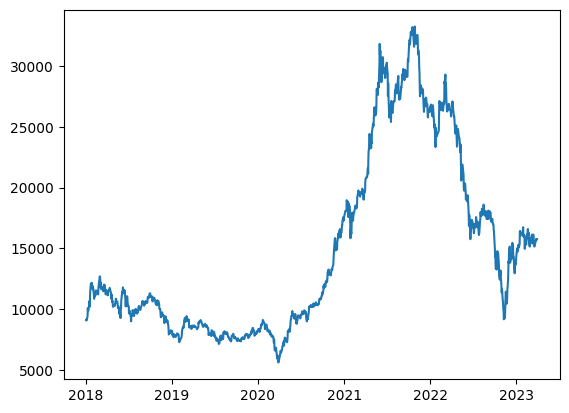

In [ ]:
plt.plot(df["Trading date"], df["Closing price"])

In [ ]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)

  df.set_index('Trading date', inplace=True)

  for i in range(1, n_steps+1):
    df[f'Closing price(t-{i})'] = df['Closing price'].shift(i)

  df.dropna(inplace=True)
  return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

,Closing price,Closing price(t-1),Closing price(t-2),Closing price(t-3),Closing price(t-4),Closing price(t-5),Closing price(t-6),Closing price(t-7)
Trading date,,,,,,,,
2018-01-11,9845.9,9845.9,10074.4,9426.9,9141.2,9179.3,9065.1,9084.1
2018-01-12,9922.0,9845.9,9845.9,10074.4,9426.9,9141.2,9179.3,9065.1
2018-01-15,10398.1,9922.0,9845.9,9845.9,10074.4,9426.9,9141.2,9179.3
2018-01-16,10664.8,10398.1,9922.0,9845.9,9845.9,10074.4,9426.9,9141.2
2018-01-17,10207.7,10664.8,10398.1,9922.0,9845.9,9845.9,10074.4,9426.9
...,...,...,...,...,...,...,...,...
2023-03-27,15757.6,15454.5,15454.5,15378.8,15492.4,15151.5,15454.5,15795.5
2023-03-28,15681.8,15757.6,15454.5,15454.5,15378.8,15492.4,15151.5,15454.5
2023-03-29,15757.6,15681.8,15757.6,15454.5,15454.5,15378.8,15492.4,15151.5


In [ ]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[ 9845.9,  9845.9, 10074.4, ...,  9179.3,  9065.1,  9084.1],
       [ 9922. ,  9845.9,  9845.9, ...,  9141.2,  9179.3,  9065.1],
       [10398.1,  9922. ,  9845.9, ...,  9426.9,  9141.2,  9179.3],
       ...,
       [15757.6, 15681.8, 15757.6, ..., 15378.8, 15492.4, 15151.5],
       [15757.6, 15757.6, 15681.8, ..., 15454.5, 15378.8, 15492.4],
       [15757.6, 15757.6, 15757.6, ..., 15454.5, 15454.5, 15378.8]])

In [ ]:
shifted_df_as_np.shape

(1301, 8)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[-0.69385008, -0.69385008, -0.67731572, ..., -0.74208557,
        -0.75034914, -0.74897429],
       [-0.68834345, -0.69385008, -0.69385008, ..., -0.74484251,
        -0.74208557, -0.75034914],
       [-0.65389263, -0.68834345, -0.69385008, ..., -0.72416912,
        -0.74484251, -0.74208557],
       ...,
       [-0.26607669, -0.27156161, -0.26607669, ..., -0.29348683,
        -0.28526668, -0.30993437],
       [-0.26607669, -0.26607669, -0.27156161, ..., -0.28800915,
        -0.29348683, -0.28526668],
       [-0.26607669, -0.26607669, -0.26607669, ..., -0.28800915,
        -0.28800915, -0.29348683]])

In [ ]:
X_1 = shifted_df_as_np[:, 1:]
y_1 = shifted_df_as_np[:, 0]
X_1.shape, y_1.shape


array([[-0.69385008, -0.67731572, -0.72416912, ..., -0.74208557,
        -0.75034914, -0.74897429],
       [-0.69385008, -0.69385008, -0.67731572, ..., -0.74484251,
        -0.74208557, -0.75034914],
       [-0.68834345, -0.69385008, -0.69385008, ..., -0.72416912,
        -0.74484251, -0.74208557],
       ...,
       [-0.27156161, -0.26607669, -0.28800915, ..., -0.29348683,
        -0.28526668, -0.30993437],
       [-0.26607669, -0.27156161, -0.26607669, ..., -0.28800915,
        -0.29348683, -0.28526668],
       [-0.26607669, -0.26607669, -0.27156161, ..., -0.28800915,
        -0.28800915, -0.29348683]])

In [ ]:
X_1 = dc(np.flip(X_1, axis = 1))
X_1

array([[-0.74897429, -0.75034914, -0.74208557, ..., -0.72416912,
        -0.67731572, -0.69385008],
       [-0.75034914, -0.74208557, -0.74484251, ..., -0.67731572,
        -0.69385008, -0.69385008],
       [-0.74208557, -0.74484251, -0.72416912, ..., -0.69385008,
        -0.69385008, -0.68834345],
       ...,
       [-0.30993437, -0.28526668, -0.29348683, ..., -0.28800915,
        -0.26607669, -0.27156161],
       [-0.28526668, -0.29348683, -0.28800915, ..., -0.26607669,
        -0.27156161, -0.26607669],
       [-0.29348683, -0.28800915, -0.28800915, ..., -0.27156161,
        -0.26607669, -0.26607669]])

In [ ]:
split_index = int(len(df[(df['Trading date'] >= TRAIN_START) & (df['Trading date'] <= TRAIN_END)].reset_index(drop=True)))
split_index

1015

In [ ]:
X_1_train = X_1[:split_index]
X_1_test = X_1[split_index:]

y_1_train = y_1[:split_index]
y_1_test = y_1[split_index:]



X_1_train = torch.tensor(X_1_train).float()
X_1_test = torch.tensor(X_1_test).float()

y_1_train = torch.tensor(y_1_train).float()
y_1_test = torch.tensor(y_1_test).float()

X_1_train.shape, X_1_test.shape, y_1_train.shape, y_1_test.shape

(torch.Size([1015, 7]),
 torch.Size([286, 7]),
 torch.Size([1015]),
 torch.Size([286]))

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset1(Dataset):
  def __init__(self, X_1, y_1):
    self.X_1 = X_1
    self.y_1 = y_1
  def __len__(self):
    return len(self.X_1)

  def __getitem__(self, i):
      return self.X_1[i], self.y_1[i]

train_dataset = TimeSeriesDataset1(X_1_train, y_1_train)
test_dataset = TimeSeriesDataset1(X_1_test, y_1_test)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True )
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(DEVICE), batch[1].to(DEVICE)
  print(x_batch.shape, y_batch.shape)
  break

class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(DEVICE)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(DEVICE)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(1, 4, 1)
model.to(DEVICE)
model


def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(DEVICE), batch[1].to(DEVICE)

        x_batch = x_batch.unsqueeze(-1).float()
        y_batch = y_batch.float().unsqueeze(-1)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(DEVICE), batch[1].to(DEVICE)

    with torch.no_grad():

        x_batch = x_batch.unsqueeze(-1).float()
        y_batch = y_batch.float().unsqueeze(-1)
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()


learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()



torch.Size([16, 7]) torch.Size([16])
Epoch: 1

Val Loss: 0.035
***************************************************

Val Loss: 0.072
***************************************************

Val Loss: 0.101
***************************************************

Val Loss: 0.121
***************************************************

Val Loss: 0.130
***************************************************

Val Loss: 0.133
***************************************************

Val Loss: 0.134
***************************************************

Val Loss: 0.137
***************************************************

Val Loss: 0.140
***************************************************

Val Loss: 0.143
***************************************************

Val Loss: 0.143
***************************************************

Val Loss: 0.145
***************************************************

Val Loss: 0.146
***************************************************

Val Loss: 0.146
****************************************

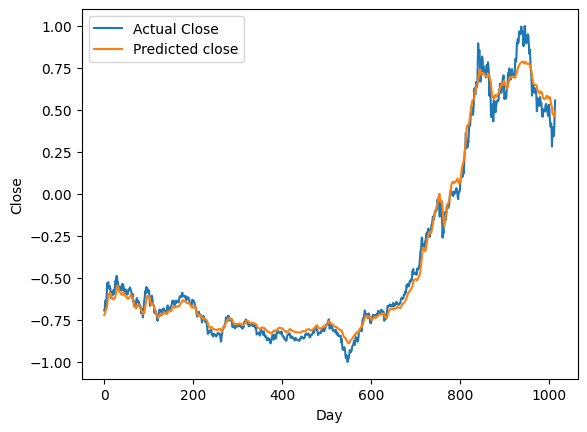

In [ ]:
import matplotlib.pyplot as plt


with torch.no_grad():
  X_input = X_1_train.unsqueeze(-1).float().to(DEVICE)
  predicted = model(X_input.to(DEVICE)).to('cpu').numpy()

plt.plot(y_1_train, label ='Actual Close')
plt.plot(predicted, label ='Predicted close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

Train rows: 1015 Test rows: 308


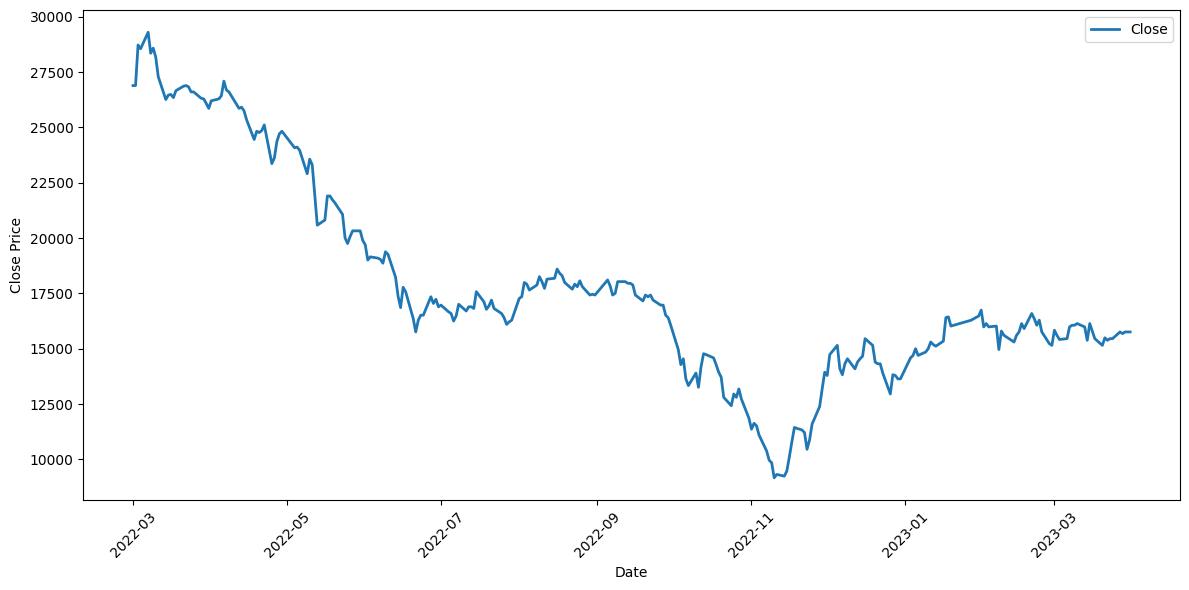

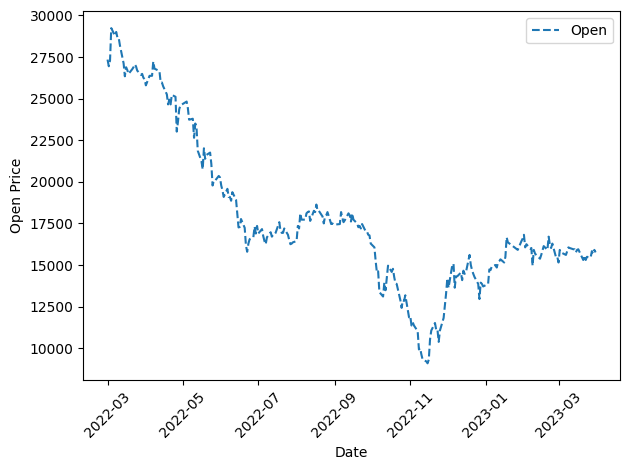

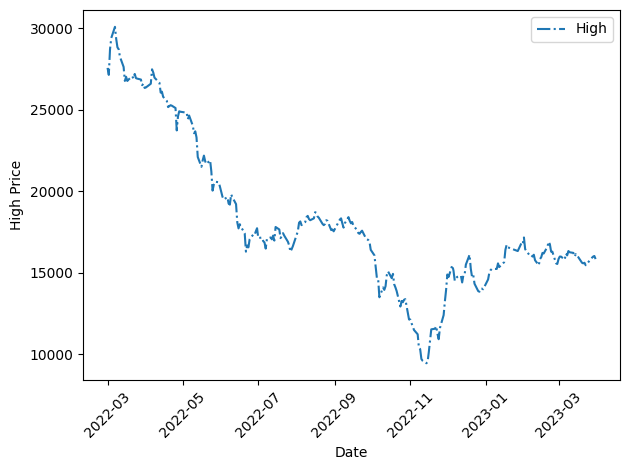

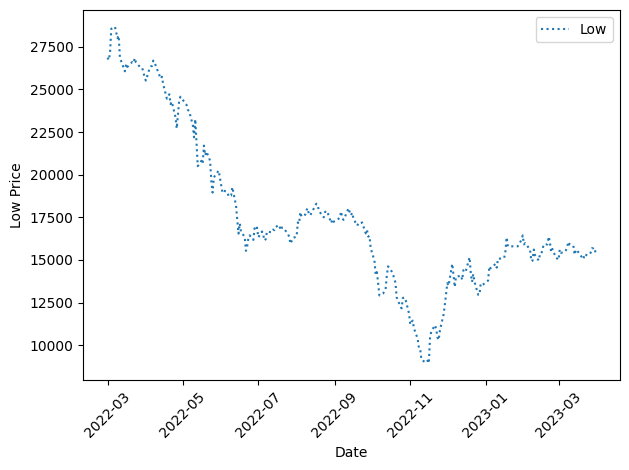

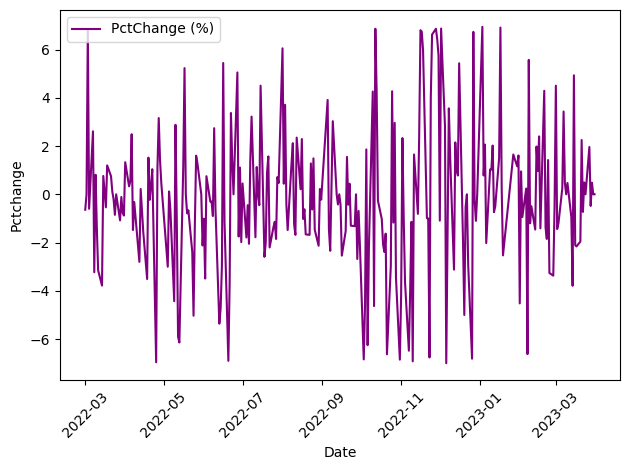

ARIMA best order: (2, 1, 2) AIC: 14732.893195972036
ARIMA metrics: {'R2': -2.8634409201683133, 'MAPE': np.float64(56.56708772250063), 'RMSE': 9871.292688589765}


In [ ]:


def mape(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  denom = np.where(y_true == 0, 1e-8, y_true)
  return np.mean(np.abs((y_true - y_pred)/ denom)) * 100

def rmse(y_true, y_pred):
  return sqrt(mean_squared_error(y_true, y_pred))

def parse_volume(x):
  if pd.isna(x): return np.nan
  s = str(x).strip().replace(",", "")
  try:
        if s.endswith("M") or s.endswith("m"):
            return float(s[:-1]) * 1_000_000
        if s.endswith("K") or s.endswith("k"):
            return float(s[:-1]) * 1_000
        # possible suffixes or raw numeric
        return float(s)
  except:

        s2 = s.replace(" ", "")
        try:
            if s2.endswith("M") or s2.endswith("m"):
                return float(s2[:-1]) * 1_000_000
            if s2.endswith("K") or s2.endswith("k"):
                return float(s2[:-1]) * 1_000
        except:
            return np.nan
# Percent cleanup (handles '0.0048' or '0.48%' or '0.48')
def parse_pct(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    if "%" in s:
        try:
            return float(s.replace("%",""))/100.0
        except:
            return np.nan
    else:
        try:
            return float(s)
        except:
            return np.nan




df = pd.read_excel(file_path)

cols = df.columns.tolist()

col_map = {}
for c in cols:
    lc = c.lower()
    if "date" in lc:
        col_map[c] = "Date"
    elif "closing" in lc or "close" in lc:
        col_map[c] = "Close"
    elif "opening" in lc or "open" in lc:
        col_map[c] = "Open"
    elif "highest" in lc or "high" in lc:
        col_map[c] = "High"
    elif "lowest" in lc or "low" in lc:
        col_map[c] = "Low"
    elif "volume" in lc:
        col_map[c] = "Volume"
    elif "percentage" in lc or "change" in lc:
        col_map[c] = "PctChange"

df = df.rename(columns = col_map)

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

df = df.sort_values('Date').reset_index(drop = True)

required = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'PctChange']
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in dataset: {missing}. Columns found: {df.columns.tolist()}")

df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Open']  = pd.to_numeric(df['Open'], errors='coerce')
df['High']  = pd.to_numeric(df['High'], errors='coerce')
df['Low']   = pd.to_numeric(df['Low'], errors='coerce')
df['Volume'] = df['Volume'].apply(parse_volume).astype(float)
df['PctChange'] = df['PctChange'].apply(parse_pct).astype(float)

train = df[(df['Date'] >= TRAIN_START) & (df['Date'] <= TRAIN_END)].reset_index(drop=True)
test = df[(df['Date'] >= TEST_START) & (df['Date'] <= TEST_END)].reset_index(drop=True)

if len(train) == 0 or len(test) == 0:
  raise ValueError("Train or test slice empty — check dates vs dataset range.")

print("Train rows:", len(train), "Test rows:", len(test))



# Plot original actual values
actual_values = df[(df['Date'] >= "2022-03-01") & (df['Date'] <= "2023-03-31")]

plt.figure(figsize=(12,6))
plt.plot(actual_values['Date'], actual_values['Close'], label="Close", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUTDIR / "actual_close.png", dpi=150)
plt.show()

plt.plot(actual_values['Date'], actual_values['Open'], label="Open", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUTDIR / "actual_open.png", dpi=150)
plt.show()


plt.plot(actual_values['Date'], actual_values['High'], label="High", linestyle="-.")
plt.xlabel("Date")
plt.ylabel("High Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUTDIR / "actual_high.png", dpi=150)
plt.show()

plt.plot(actual_values['Date'], actual_values['Low'], label="Low", linestyle=":")
plt.xlabel("Date")
plt.ylabel("Low Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUTDIR / "actual_low.png", dpi=150)
plt.show()

plt.plot(actual_values['Date'], actual_values['PctChange']*100, label="PctChange (%)", color="purple")
plt.xlabel("Date")
plt.ylabel("Pctchange")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUTDIR / "actual_pctchange.png", dpi=150)
plt.show()



y_train = train['Close'].values.astype(float)
best_aic = np.inf
best_order = None
best_arima = None
for p in range(0,4):
  for q in range(0,4):
    try:
      m = ARIMA(y_train, order= (p,1,q)).fit()
      if m.aic < best_aic:
        best_aic = m.aic
        best_order = (p,1,q)
        best_arima = m
    except Exception:
        continue
print("ARIMA best order:", best_order, "AIC:", best_aic)
n_test = len(test)
arima_pred = np.array(best_arima.forecast(steps=n_test)).astype(float)
y_test = test['Close'].values

arima_metrics = {"R2": r2_score(y_test, arima_pred), "MAPE": mape(y_test, arima_pred), "RMSE": rmse(y_test, arima_pred)}
print("ARIMA metrics:", arima_metrics)





cfg lb5 u32 bs16 ep50 -> val_rmse 0.0275
cfg lb5 u32 bs16 ep100 -> val_rmse 0.0234
cfg lb5 u32 bs32 ep50 -> val_rmse 0.0284
cfg lb5 u32 bs32 ep100 -> val_rmse 0.0288
cfg lb5 u64 bs16 ep50 -> val_rmse 0.0227
cfg lb5 u64 bs16 ep100 -> val_rmse 0.0273
cfg lb5 u64 bs32 ep50 -> val_rmse 0.0246
cfg lb5 u64 bs32 ep100 -> val_rmse 0.0252
cfg lb10 u32 bs16 ep50 -> val_rmse 0.0307
cfg lb10 u32 bs16 ep100 -> val_rmse 0.0350
cfg lb10 u32 bs32 ep50 -> val_rmse 0.0235
cfg lb10 u32 bs32 ep100 -> val_rmse 0.0252
cfg lb10 u64 bs16 ep50 -> val_rmse 0.0230
cfg lb10 u64 bs16 ep100 -> val_rmse 0.0380
cfg lb10 u64 bs32 ep50 -> val_rmse 0.0296
cfg lb10 u64 bs32 ep100 -> val_rmse 0.0222
cfg lb20 u32 bs16 ep50 -> val_rmse 0.0238
cfg lb20 u32 bs16 ep100 -> val_rmse 0.0327
cfg lb20 u32 bs32 ep50 -> val_rmse 0.0244
cfg lb20 u32 bs32 ep100 -> val_rmse 0.0311
cfg lb20 u64 bs16 ep50 -> val_rmse 0.0241
cfg lb20 u64 bs16 ep100 -> val_rmse 0.0257
cfg lb20 u64 bs32 ep50 -> val_rmse 0.0265
cfg lb20 u64 bs32 ep100 -> val_

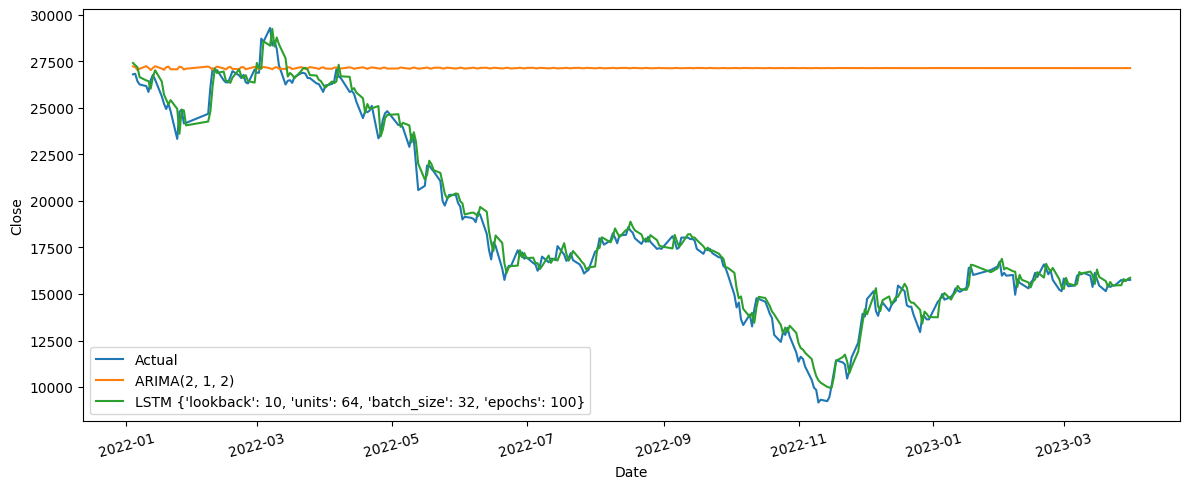

In [ ]:
# LSTM

features = ['Open','High','Low','Volume','PctChange']
target = 'Close'

train_X = train[features].astype(float).values
test_X = test[features].astype(float).values
train_y = train[target].astype(float).values.reshape(-1,1)
test_y = test[target].astype(float).values.reshape(-1,1)

# Scale features
mms = MinMaxScaler(feature_range=(0,1))
mms.fit(train_X)
train_X_mm = mms.transform(train_X)
test_X_mm = mms.transform(test_X)

ss = StandardScaler()
ss.fit(train_X_mm)
train_X_scaled = ss.transform(train_X_mm)
test_X_scaled = ss.transform(test_X_mm)

#  Scale target (Close) separately
y_scaler = MinMaxScaler()
train_y_scaled = y_scaler.fit_transform(train_y)
test_y_scaled = y_scaler.transform(test_y)




def make_sequences(X_scaled, y_scaled, lookback):
    Xs, Ys = [], []
    for i in range(lookback, len(X_scaled)):
        Xs.append(X_scaled[i-lookback:i, :])
        Ys.append(y_scaled[i])
    Xs, Ys = np.array(Xs), np.array(Ys)
    min_len = min(len(Xs), len(Ys))
    return Xs[:min_len], Ys[:min_len]


def make_test_sequences(train_X_scaled, test_X_scaled, train_y_scaled, test_y_scaled, lookback):
    combined_X = np.vstack([train_X_scaled[-lookback:], test_X_scaled])
    combined_y = np.concatenate([train_y_scaled[-lookback:], test_y_scaled])
    Xs, Ys = [], []
    for i in range(lookback, combined_X.shape[0]):
        Xs.append(combined_X[i-lookback:i, :])
        Ys.append(combined_y[i])
    Xs, Ys = np.array(Xs), np.array(Ys)
    min_len = min(len(Xs), len(Ys))
    return Xs[:min_len], Ys[:min_len]


class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32).reshape(-1,1)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class LSTMNet(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1, dropout=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out


best_cfg = None
best_val_rmse = np.inf
best_model_state = None

val_frac = 0.1
val_idx = int(len(train_X_scaled)*(1-val_frac))
X_train_base = train_X_scaled[:val_idx]
y_train_base = train_y_scaled[:val_idx]
X_val_base = train_X_scaled[val_idx:]
y_val_base = train_y_scaled[val_idx:]

for lookback in GRID['lookback']:
    X_train_seq, y_train_seq = make_sequences(X_train_base, y_train_base, lookback)
    X_val_seq, y_val_seq = make_sequences(np.vstack([X_train_base[-lookback:], X_val_base]),
                                          np.concatenate([y_train_base[-lookback:], y_val_base]), lookback)
    if len(X_train_seq) < 10 or len(X_val_seq) < 10:
        continue
    for units in GRID['units']:
        for bs in GRID['batch_size']:
            for epochs in GRID['epochs']:
                train_ds = TimeSeriesDataset(X_train_seq, y_train_seq)
                val_ds = TimeSeriesDataset(X_val_seq, y_val_seq)
                train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
                val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False)

                model = LSTMNet(n_features=X_train_seq.shape[2], hidden_size=units).to(DEVICE)
                opt = torch.optim.Adam(model.parameters(), lr=1e-3)
                loss_fn = nn.MSELoss()
                best_local = np.inf; wait = 0; patience = 8
                for ep in range(epochs):
                    model.train()
                    losses = []
                    for xb, yb in train_loader:
                        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                        opt.zero_grad()
                        out = model(xb)
                        loss = loss_fn(out, yb)
                        loss.backward()
                        opt.step()
                        losses.append(loss.item())
                    # val
                    model.eval()
                    preds_val = []
                    trues_val = []
                    with torch.no_grad():
                        for xb, yb in val_loader:
                            xb = xb.to(DEVICE)
                            out = model(xb).cpu().numpy().flatten()
                            preds_val.extend(out.tolist())
                            trues_val.extend(yb.numpy().flatten().tolist())
                    val_rm = rmse(trues_val, preds_val)
                    if val_rm < best_local - 1e-6:
                        best_local = val_rm
                        wait = 0
                        best_local_state = model.state_dict()
                    else:
                        wait += 1
                        if wait >= patience:
                            break
                model.load_state_dict(best_local_state)
                model.eval()
                preds_val, trues_val = [], []
                with torch.no_grad():
                    for xb, yb in val_loader:
                        xb = xb.to(DEVICE)
                        out = model(xb).cpu().numpy().flatten()
                        preds_val.extend(out.tolist()); trues_val.extend(yb.numpy().flatten().tolist())
                val_rm = rmse(trues_val, preds_val)
                print(f"cfg lb{lookback} u{units} bs{bs} ep{epochs} -> val_rmse {val_rm:.4f}")
                if val_rm < best_val_rmse:
                    best_val_rmse = val_rm
                    best_cfg = {"lookback":lookback,"units":units,"batch_size":bs,"epochs":epochs}
                    best_model_state = best_local_state

print("Best LSTM cfg (by val RMSE):", best_cfg, "val_rmse:", best_val_rmse)

# Retrain best model on full train data
lookback = best_cfg['lookback']
X_full_seq, y_full_seq = make_sequences(train_X_scaled, train_y_scaled, lookback)
train_ds_full = TimeSeriesDataset(X_full_seq, y_full_seq)
train_loader_full = DataLoader(train_ds_full, batch_size=best_cfg['batch_size'], shuffle=True)

model = LSTMNet(n_features=X_full_seq.shape[2], hidden_size=best_cfg['units']).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

best_loss = np.inf; wait=0; patience=10
for ep in range(best_cfg['epochs']):
    model.train()
    losses = []
    for xb, yb in train_loader_full:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    avg = np.mean(losses)
    if avg < best_loss - 1e-9:
        best_loss = avg; wait = 0; best_state_full = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            break

model.load_state_dict(best_state_full)
model.eval()

# Test sequences
X_test_seq, y_test_seq = make_test_sequences(train_X_scaled, test_X_scaled, train_y_scaled, test_y_scaled, lookback)
test_ds = TimeSeriesDataset(X_test_seq, y_test_seq)
test_loader = DataLoader(test_ds, batch_size=best_cfg['batch_size'], shuffle=False)

preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        out = model(xb).cpu().numpy().flatten()
        preds.extend(out.tolist())
        trues.extend(yb.numpy().flatten().tolist())

# Inverse transform back to original scale
lstm_pred = y_scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
trues = y_scaler.inverse_transform(np.array(trues).reshape(-1,1)).flatten()

lstm_metrics = {"R2": r2_score(trues, lstm_pred),
                "MAPE": mape(trues, lstm_pred),
                "RMSE": rmse(trues, lstm_pred)}
print("LSTM metrics on test:", lstm_metrics)

# Save results
results_df = pd.DataFrame({
    "Date": test['Date'].values[-len(trues):],
    "Actual": trues,
    "ARIMA_Pred": arima_pred,
    "LSTM_Pred": lstm_pred
})
results_df.to_csv(OUTDIR / "predictions_full_features.csv", index=False)
pd.DataFrame([{"Model":"ARIMA", **arima_metrics}, {"Model":"LSTM", **lstm_metrics}]).to_csv(OUTDIR/"metrics_full_features.csv", index=False)





# Plot
plt.figure(figsize=(12,5))
plt.plot(test['Date'], trues, label="Actual")
plt.plot(test['Date'], arima_pred, label=f"ARIMA{best_order}")
plt.plot(test['Date'], lstm_pred, label=f"LSTM {best_cfg}")
plt.legend(); plt.xticks(rotation=15)
plt.xlabel("Date"); plt.ylabel("Close")
plt.tight_layout()
plt.savefig(OUTDIR / "compare_plot.png", dpi=150)
print("Saved to:", OUTDIR)
